In [3]:
#!pip install botorch
#!pip install pyDOE
#!pip install openpyxl
#!pip install smt
#!pip install scikit-optimize

In [4]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs



In [5]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
#from botorch.transforms import Standardize
#from botorch.utils.transforms import euclidean_distance



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


#Generate points

#import data

# Inputs

check the sampling file

# Outputs

['102119 (1).csv', '102119 (2).csv', '102119 (3).csv', '102119 (4).csv', '102119 (5).csv', '102119 (6).csv', '102119 (7).csv', '102119 (8).csv', '102119 (9).csv', '102119 (10).csv', '102119 (11).csv', '102119 (12).csv', '102119 (13).csv', '102119 (14).csv', '102119 (15).csv', '102119 (16).csv', '102119 (17).csv', '102119 (18).csv', '102119 (19).csv', '102119 (20).csv', '102119 (21).csv', '102119 (22).csv', '102119 (23).csv', '102119 (24).csv', '102119 (25).csv', '102119 (26).csv', '102119 (27).csv', '102119 (28).csv', '102119 (29).csv', '102119 (30).csv', '102119 (31).csv', '102119 (32).csv', '102119 (33).csv', '102119 (34).csv', '102119 (35).csv', '102119 (36).csv', '102119 (37).csv', '102119 (38).csv', '102119 (39).csv', '102119 (40).csv', '102119 (41).csv', '102119 (42).csv', '102119 (43).csv', '102119 (44).csv', '102119 (45).csv', '102119 (46).csv', '102119 (47).csv', '102119 (48).csv']


Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 94.97it/s]


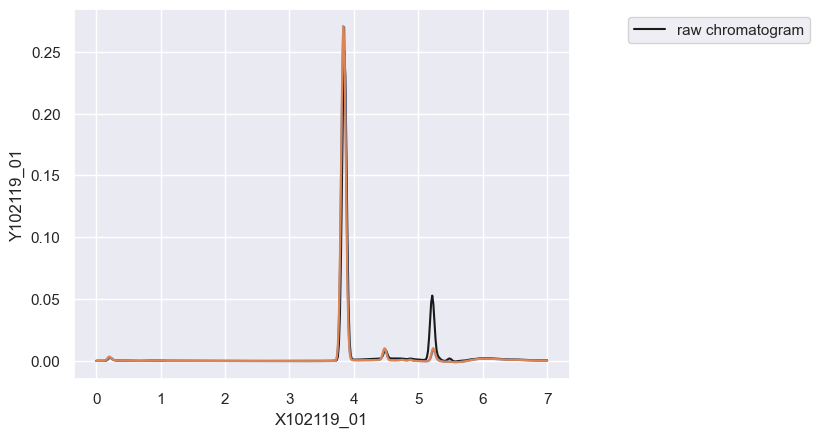

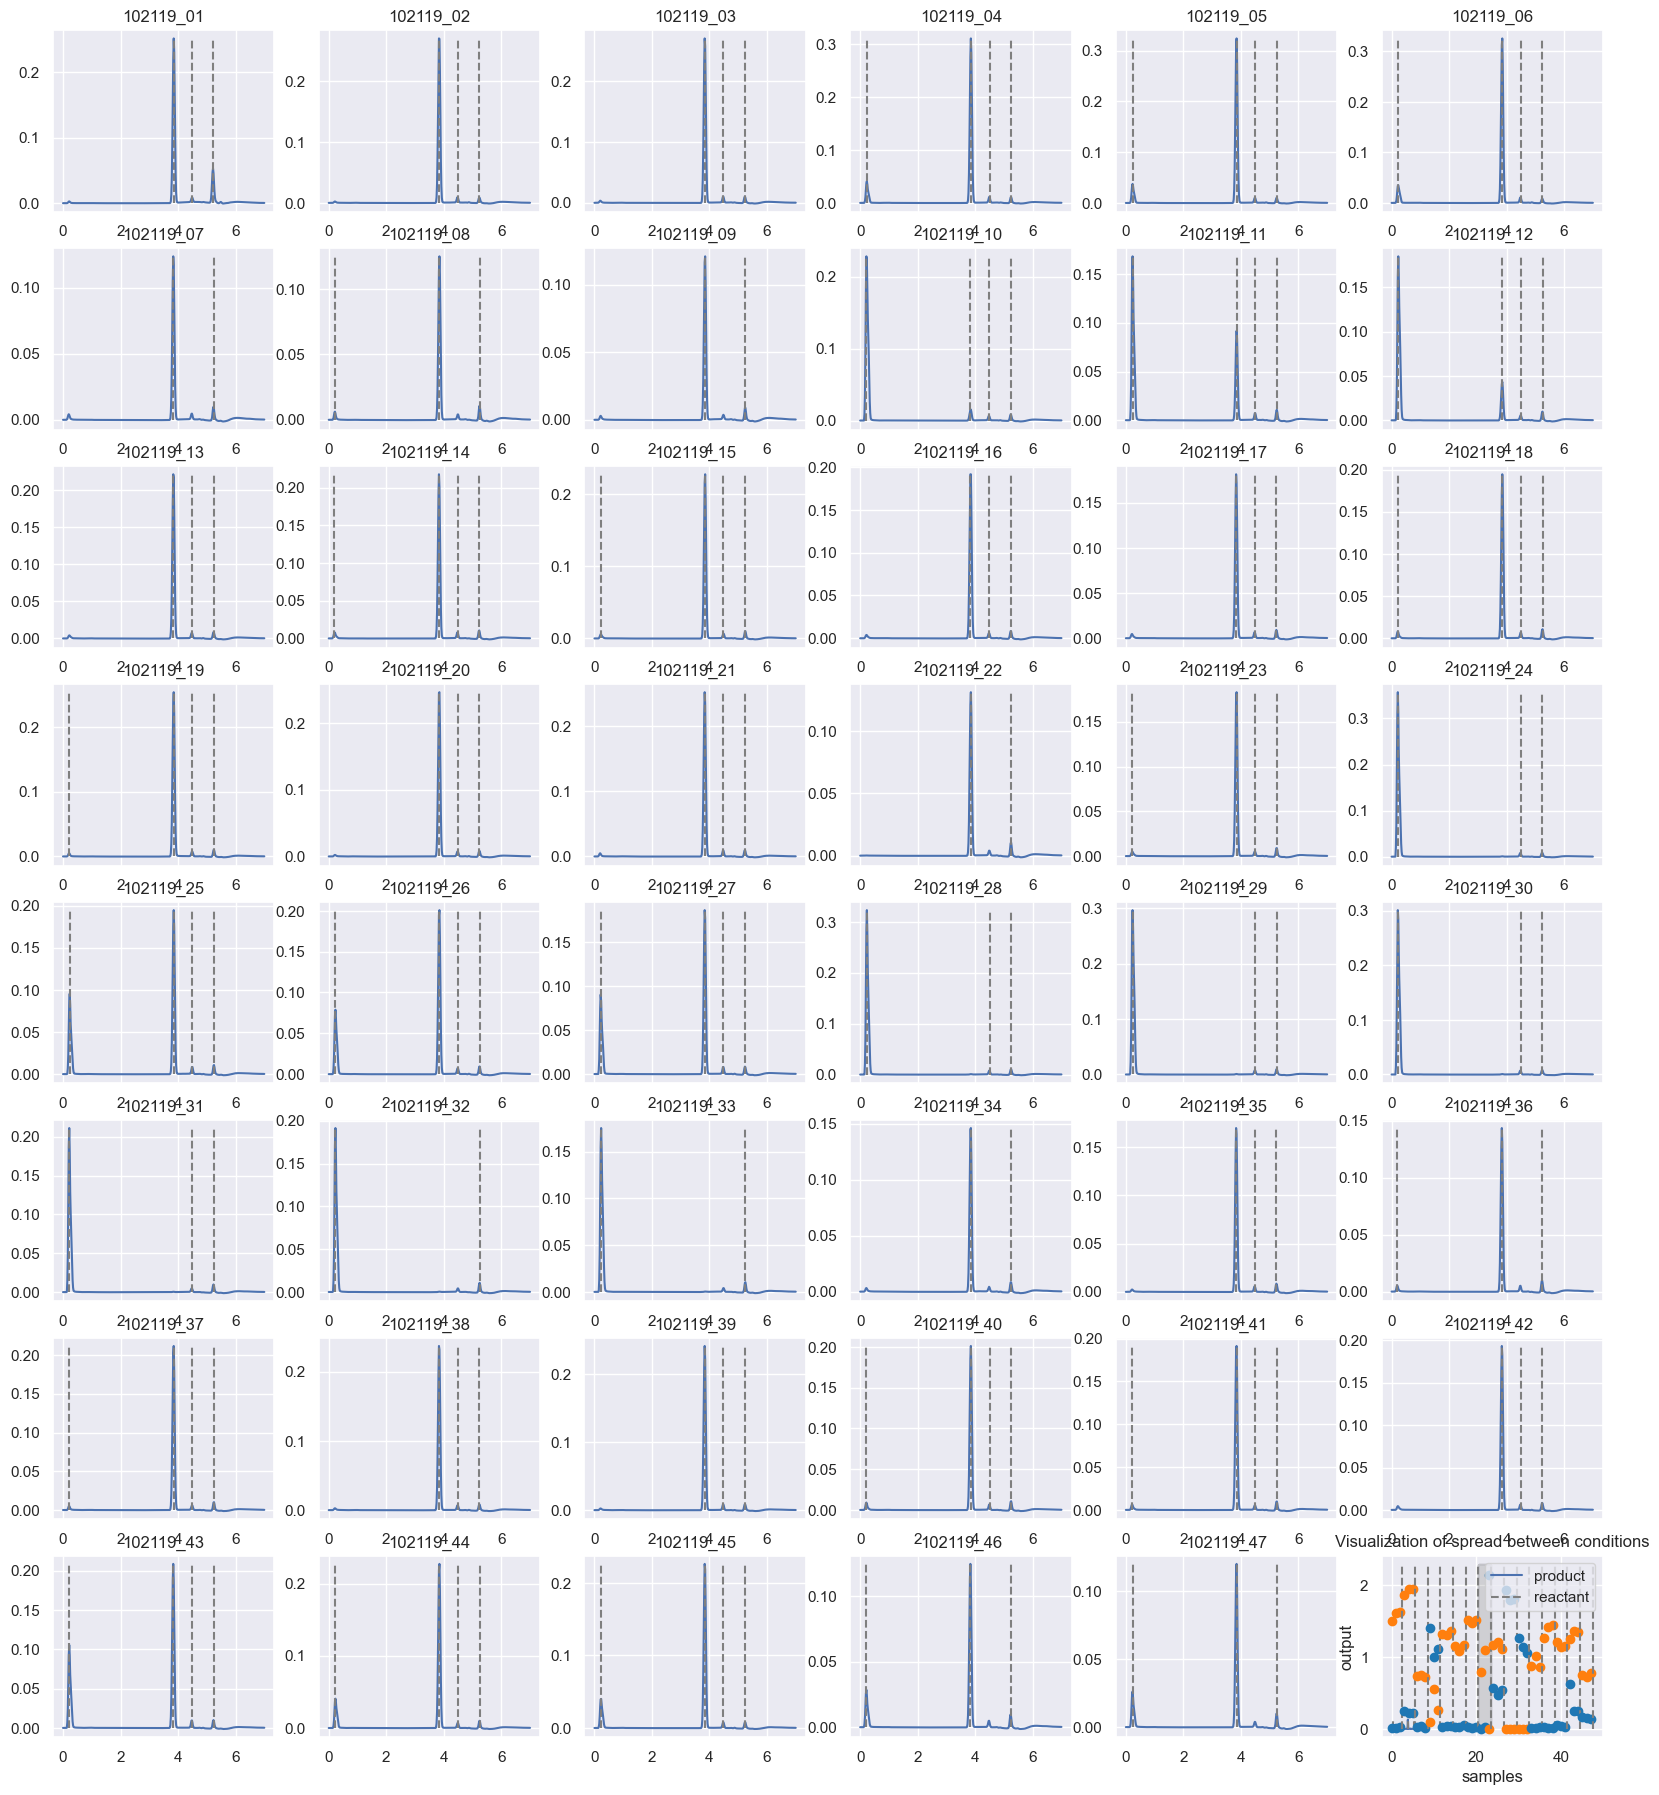

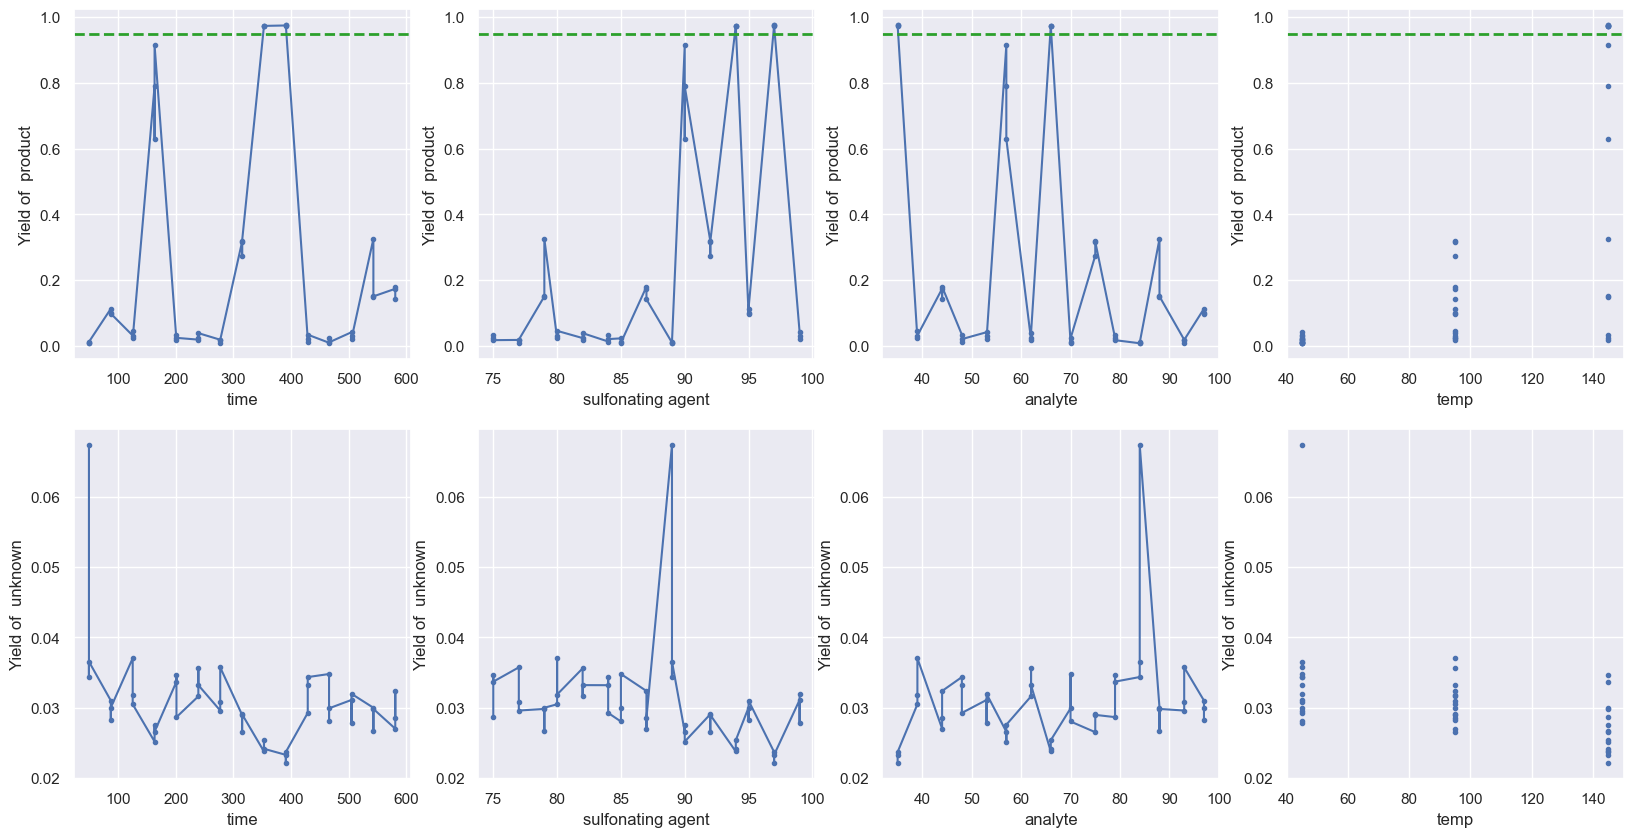

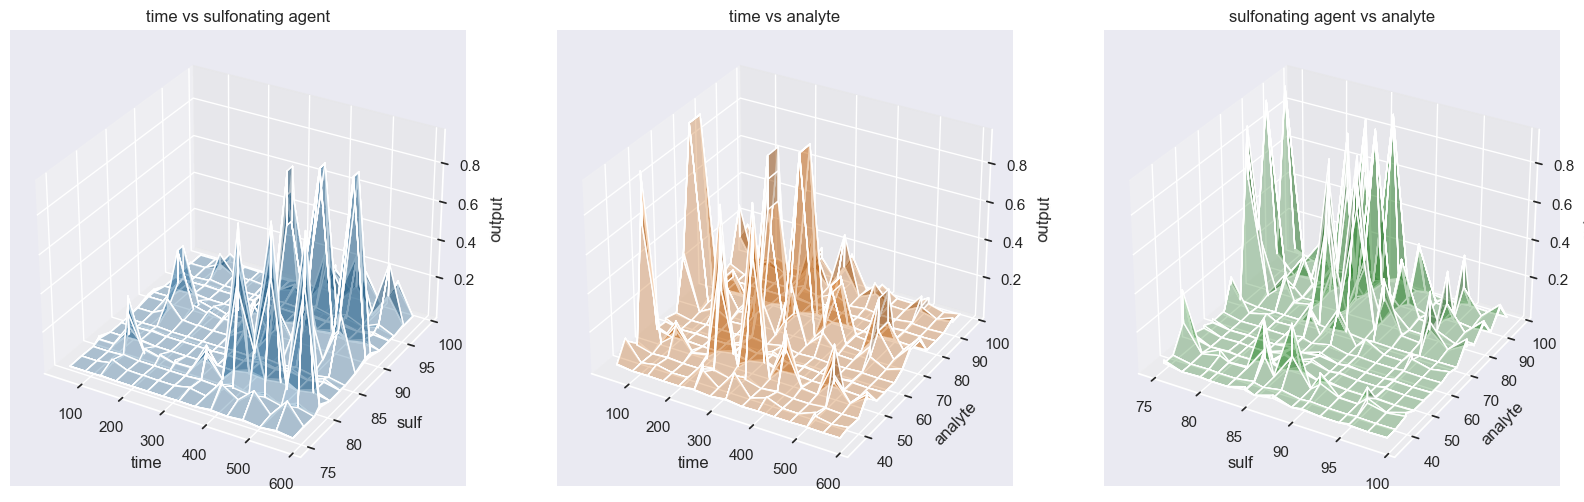

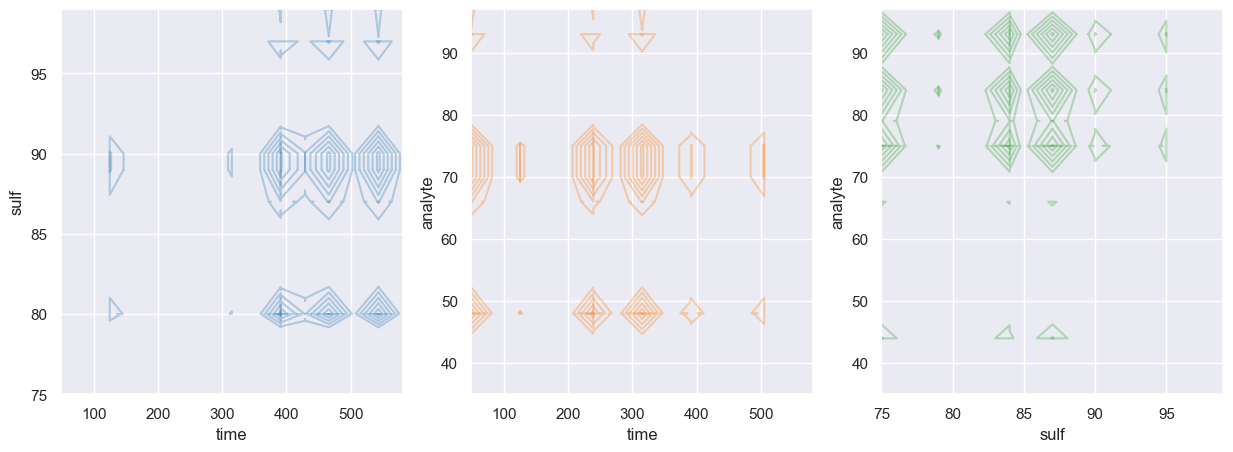

In [7]:
from PNNL_spectra_extract import data_102119
#data_102119.head(16)[['time','temp','analyte','yield product']]
# /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
# %run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

In [8]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


In [9]:
std_data = data_102119.groupby('time').std().reset_index()[['time','temp','sulf','analyte','yield product']]
std_data

,time,temp,sulf,analyte,yield product
0,49,0.0,0.0,0.0,0.002110
1,87,0.0,0.0,0.0,0.007884
2,125,0.0,0.0,0.0,0.011663
3,163,0.0,0.0,0.0,0.142828
4,201,0.0,0.0,0.0,0.008250
5,239,0.0,0.0,0.0,0.010353
6,277,0.0,0.0,0.0,0.005608
7,315,0.0,0.0,0.0,0.025185
8,353,0.0,0.0,0.0,0.001016
9,391,0.0,0.0,0.0,0.000763


# Start of BO

In [10]:
# Modify the objective function to minimize the L2 distance between the predicted and reference RGB values
def quary(predicted_composition,pool_y,pool_x):
    vector_y = []
    vector_x = []
    id = []
    # Reference RGB value (the desired or ideal RGB you want to achieve)
    #desired_composition = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=dtype)
    # Calculate the Euclidean distance between measured and desired compositions
    #distance_ref = desired_composition - predicted_composition #d2 = cand-reference

    for i in range(len(predicted_composition)):
        pool_distance = torch.norm(predicted_composition[i]-pool_x,dim=1)

        vector_y.append(pool_y[pool_distance.argmin()])
        vector_x.append(pool_x[pool_distance.argmin()])

        indices_to_remove = pool_distance.argmin()
        # Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
        mask = torch.ones(pool_x.size(0), dtype=torch.bool)
        mask[indices_to_remove] = 0

        # Use the mask to select elements from the tensor
        pool_y = pool_y[mask]
        pool_x = pool_x[mask]

        #id.append(torch.norm(pool_distance,dim=1).argmin().item())

    vector_y = np.array([element for element in vector_y])
    vector_x = np.array([element for element in vector_x])
    #d_pool =  torch.abs(pool_y - predicted_composition).mean(axis=1)
    #actual = actual_pool[distance]
    #candidate = actual_candidates[distance]
    return torch.tensor(vector_y),torch.tensor(vector_x),pool_y, pool_x 


In [11]:
#Setting up the data
#reference = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=torch.float32) ##??
# x = torch.tensor([data_102119['time'],data_102119['temp'],data_102119['sulf'],data_102119['analyte']],dtype=torch.float32).T#[:48]
# y = torch.tensor(data_102119['yield product'],dtype=torch.float32).reshape(-1,1)

x = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)


In [12]:
# np.random.seed(10)
# x_try = x[np.random.choice(y.shape[0], 5, replace=False)]
# quary(x_try,y,x)[0], quary(torch.rand(8,4),y,x)[2].shape

#BO

Reference: https://gist.github.com/danhphan/af53fb7958a28c2e2d514221ea83bd9c

#Bayesian Optimization

https://distill.pub/2020/bayesian-optimization/

https://github.com/pytorch/botorch/issues/546

In [13]:
train_size = 2

rand_id = []
for n in range(20):
    np.random.seed(n)
    random_id = np.random.choice(y.shape[0], size=train_size, replace=False)
    rand_id.append(random_id)

test_x = torch.tensor(x[rand_id[0]], dtype=dtype).to(device=device, dtype=dtype)
test_y = torch.tensor(y[rand_id[0]], dtype=dtype)

test_x, test_y,rand_id[0]

(tensor([[ 87.,  95.,  95.,  97.],
         [277.,  45.,  77.,  93.]]),
 tensor([[0.1039],
         [0.0151]]),
 array([1, 6]))

In [14]:
abs(y).T.sort()

torch.return_types.sort(
values=tensor([[0.0099, 0.0143, 0.0151, 0.0225, 0.0251, 0.0270, 0.0313, 0.0332, 0.1039,
         0.1650, 0.2077, 0.3035, 0.7777, 0.9730, 0.9749]]),
indices=tensor([[ 0, 11,  6, 10,  4,  5, 12,  2,  1, 14, 13,  7,  3,  8,  9]]))

In [15]:
bounds = torch.tensor([[0., 0., 0.,0.], [600., 145., 100.,100.]], dtype=dtype, device=device)
batch_size = 1 #train_size

iteration_number=(len(avg_data)-train_size)//batch_size
iterations = list(range(0, iteration_number+1))#list(range(1, iteration_number+1))

# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
target_vector = torch.tensor([1],dtype=dtype) # target is 95% or highers
iteration_number

13

In [16]:
iterations = list(range(1, iteration_number+1))
len(iterations)

13

In [17]:
def prediction(cand_eval,model):
    with torch.no_grad():
        posterior = model.posterior(cand_eval)
        mean = posterior.mean
        variance = posterior.variance
        return mean,variance

def BO_loop(acq_func_id,train_size,batch_size,random_id,y,x,iteration_number):
    train_x = torch.tensor(x[random_id], dtype=dtype).to(device=device, dtype=dtype)
    train_y = torch.tensor(y[random_id], dtype=dtype)

    indices_to_remove = random_id 
    ## Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
    mask = torch.ones(y.size(0), dtype=torch.bool)
    mask[indices_to_remove] = 0
    y_pool = y[mask] #93 exclude training data
    x_pool = x[mask] #93 exclude training data

    ## Create the surrogate model
    gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    mean,variance = prediction(train_x,gp_model)

    means = [mean.numpy()]
    variances = [variance.numpy()]
    models = [gp_model]
    # frames_y = [train_y.cpu().numpy()]
    # frames_x = [train_x.cpu().numpy()]

    
    #best_y = train_y[torch.norm(train_y-target_vector,dim=1).argmax()].cpu().detach()
    best_y = train_y[abs(train_y-target_vector).argmax()].cpu().detach()
    best_y_values=[best_y]
    
    ## Define aquisition functions
    #acq_funcs = [ScalarizedExpectedImprovement(gp_model, best_f=best_f, target_vector=target_vector),ScalarizedUpperConfidenceBound(gp_model,kappa=2.0,target_vector=target_vector)]
    acq_funcs = [ExpectedImprovement(model=gp_model, best_f=best_y),qExpectedImprovement(model=gp_model, best_f=best_y ),UpperConfidenceBound(model=gp_model, beta=1),ProbabilityOfImprovement(model=gp_model, best_f=best_y),PosteriorMean(model=gp_model)]


    iteration = 0
    count_min = 0
    end_count = -1
    #true_min_y = y[torch.norm(y-reference,dim=1).argmin()].numpy()

    
    while iteration < iteration_number :
        #distance_min = np.linalg.norm(best_y  - target_vector)
        #if np.linalg.norm(best_y  - true_min_y) == 0.0 and count_min == 0:
        #if distance_min <= 0.025 and count_min == 0:
        ## Check if Criteria has met
        if train_y.max()>= 0.95 and variances[iteration].min() < 0.02: #count_min != 2:
        #if means[iteration].max() >= 0.90 and variances[iteration].min() <= 0.01:
            end_count = iteration+train_size
            #goal.append(end_count)
            #print("Final Iteration: "+str(end_count))    
            #count_min += 1
        #     best_y_values = np.array([element for element in best_y_values]) 
        #     print("Final Iteration: "+str(end_count))
        #     return best_y_values, frames_y, frames_x , train_y, end_count#,distance      
        #print("Iteration: "+str(iteration))
        # elif  train_y[torch.norm(train_x-frames_x[iteration],dim=1).argmin()] > 0.95 and count_min <= 3:
        #     count_min += 1
        #     goal.append(x_pool[torch.norm(train_x-candidate,dim=1).argmin()])
        #else:
        ## Optimize aquisition function to find candidates
        candidate, _ = optimize_acqf(
            acq_function=acq_funcs[acq_func_id],
            bounds=bounds,
            q=batch_size,
            num_restarts=train_size,
            raw_samples=100,
            options={"dtype": dtype, "device": device}
        )

        ## Find the values closest to the candidates in the data pool
        new_val = quary(candidate,y_pool,x_pool) #torch.tensor(objective(candidate), dtype=torch.float32).reshape(len(objective(candidate)),1)
        new_x = new_val[1] # closest x val to the candidate
        new_y = new_val[0] # closest y val to the candidate (determined by pool y vs pool x pair)

        train_x = torch.cat([train_x,  new_x ]) 
        train_y = torch.cat([train_y,  new_y ])

        y_pool = new_val[2]
        x_pool = new_val[3]

        ## Update the gaussian model
        gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_model(mll)

        models.append(gp_model)

        mean,variance = prediction(new_x,gp_model)

        best_y = train_y[torch.norm(train_y-target_vector,dim=1).argmin()].cpu().detach()
        #distance_min = np.linalg.norm(best_y  - target_vector)
        best_y_values.append(best_y)
        #best_y_values.append(train_y[train_y.mean(dim=1).argmin()].cpu().detach().numpy())
        # frames_y.append(new_val[0].cpu().detach().numpy())
        # frames_x.append(candidate.cpu().detach().numpy())
        means.append(mean.numpy())
        variances.append(variance.numpy())
        #distance.append(distance_min)

        iteration +=1
    print("Final Iteration: "+str(end_count))  
    best_y_values = np.array([element for element in best_y_values])  
    #means = np.array([element for element in means])  
    #variances = np.array([element for element in variances])  
    # print("Final Iteration: "+str(end_count))    
    return best_y_values, means, variances ,train_y,train_x,end_count,models


#best_point = train_x[train_y.argmin(), :]
#best_value = train_y.min().item()


In [18]:
num = 14
ExpImp = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
qExpImp = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
UppCB = BO_loop(acq_func_id=2,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
ProbImp = BO_loop(acq_func_id=3,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
PostMean = BO_loop(acq_func_id=4,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)

# ExpImp_8 = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id = rand_id[19],y = y,x = x,iteration_number = iteration_number)
# UppCB_8 = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id = rand_id[19],y = y,x = x,iteration_number = iteration_number)

# ExpImp_32 = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id=rand_id[3],y = y,x = x,iteration_number = iteration_number)
# UppCB_32 = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id=rand_id[3],y = y,x = x,iteration_number = iteration_number)



Final Iteration: 14
Final Iteration: 14
Final Iteration: 14
Final Iteration: 14
Final Iteration: 14


In [19]:
df_bo = pd.DataFrame({
    'EI_time':ExpImp[4][:,0].numpy(),
    'EI_temp':ExpImp[4][:,1].numpy(),
    'EI_sulf':ExpImp[4][:,2].numpy(),
    'EI_anly':ExpImp[4][:,3].numpy(),
    'EI_PM':np.concatenate(ExpImp[1]).flatten(),
    'EI_Var':np.concatenate(ExpImp[2]).flatten(),
    'EI_out':ExpImp[3].flatten(),
    'UCB_time':UppCB[4][:,0].numpy(),
    'UCB_temp':UppCB[4][:,1].numpy(),
    'UCB_sulf':UppCB[4][:,2].numpy(),
    'UCB_anly':UppCB[4][:,3].numpy(),
    'UCB_PM':np.concatenate(UppCB[1]).flatten(),
    'UCB_Var':np.concatenate(UppCB[2]).flatten(),
    'UCB_out': UppCB[3].flatten(),
    'PI_time':ProbImp[4][:,0].numpy(),
    'PI_temp':ProbImp[4][:,1].numpy(),
    'PI_sulf':ProbImp[4][:,2].numpy(),
    'PI_anly':ProbImp[4][:,3].numpy(),
    'PI_PM':np.concatenate(ProbImp[1]).flatten(),
    'PI_Var':np.concatenate(ProbImp[2]).flatten(),
    'PI_out':ProbImp[3].flatten()
})

df_bo

,EI_time,EI_temp,EI_sulf,EI_anly,EI_PM,EI_Var,EI_out,UCB_time,UCB_temp,UCB_sulf,...,UCB_PM,UCB_Var,UCB_out,PI_time,PI_temp,PI_sulf,PI_anly,PI_PM,PI_Var,PI_out
0,239.0,95.0,82.0,62.0,0.065650,0.131344,0.027045,239.0,95.0,82.0,...,0.065650,0.131344,0.027045,239.0,95.0,82.0,62.0,0.065650,0.131344,0.027045
1,163.0,145.0,90.0,57.0,0.739103,0.131344,0.777693,163.0,145.0,90.0,...,0.739103,0.131344,0.777693,163.0,145.0,90.0,57.0,0.739103,0.131344,0.777693
2,277.0,45.0,77.0,93.0,0.040390,0.037893,0.015058,125.0,95.0,80.0,...,0.056444,0.035979,0.033182,543.0,145.0,79.0,88.0,0.219814,0.028958,0.207730
3,49.0,45.0,89.0,84.0,0.027953,0.019955,0.009903,87.0,95.0,95.0,...,0.116118,0.017898,0.103900,315.0,95.0,92.0,75.0,0.305786,0.013826,0.303520
4,125.0,95.0,80.0,39.0,0.046142,0.013259,0.033182,277.0,45.0,77.0,...,0.031914,0.013041,0.015058,277.0,45.0,77.0,93.0,0.040445,0.012080,0.015058
5,429.0,45.0,84.0,48.0,0.033602,0.010077,0.022536,201.0,145.0,75.0,...,0.037533,0.009857,0.025126,581.0,95.0,87.0,44.0,0.169619,0.006008,0.164975
6,391.0,145.0,97.0,35.0,0.917717,0.016610,0.974877,49.0,45.0,89.0,...,0.024859,0.009365,0.009903,429.0,45.0,84.0,48.0,0.045856,0.009475,0.022536
7,201.0,145.0,75.0,79.0,0.044584,0.016121,0.025126,315.0,95.0,92.0,...,0.290587,0.007113,0.303520,201.0,145.0,75.0,79.0,0.025628,0.002772,0.025126
8,87.0,95.0,95.0,97.0,0.112236,0.011270,0.103900,353.0,145.0,94.0,...,0.833358,0.025701,0.972973,125.0,95.0,80.0,39.0,0.033275,0.005373,0.033182
9,315.0,95.0,92.0,75.0,0.299271,0.005354,0.303520,391.0,145.0,97.0,...,0.915699,0.016416,0.974877,353.0,145.0,94.0,66.0,0.900587,0.012317,0.972973


# plots

Text(0.5, 1.0, 'Variance')

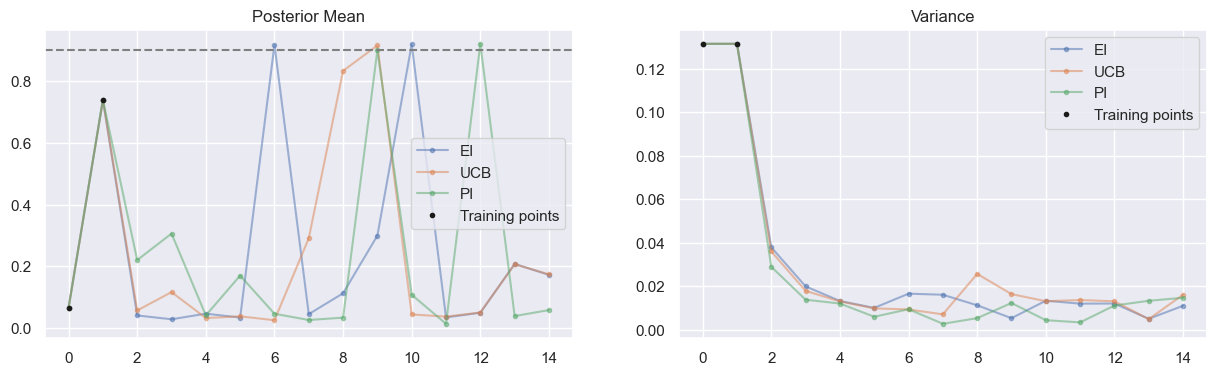

In [20]:
alpha = 0.5
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
# plt.plot(df_bo['EI_PM'][:ExpImp[5]+1],'.-',alpha =alpha )
# plt.plot(df_bo['UCB_PM'][:UppCB[5]+1],'.-',alpha =alpha)
# plt.plot(df_bo['PI_PM'][:ProbImp[5]+1],'.-',alpha =alpha)
plt.plot(df_bo['EI_PM'],'.-',alpha =alpha )
plt.plot(df_bo['UCB_PM'],'.-',alpha =alpha)
plt.plot(df_bo['PI_PM'],'.-',alpha =alpha)
plt.plot(df_bo['EI_PM'][:train_size],'k.')
plt.axhline(0.90,linestyle = '--',color = 'tab:grey')
plt.legend(['EI','UCB','PI','Training points'])
plt.title('Posterior Mean')

plt.subplot(1,2,2)
plt.plot(df_bo['EI_Var'][:ExpImp[5]+1],'.-',alpha =alpha )
plt.plot(df_bo['UCB_Var'][:UppCB[5]+1],'.-',alpha =alpha)
plt.plot(df_bo['PI_Var'][:ProbImp[5]+1],'.-',alpha =alpha)
plt.plot(df_bo['EI_Var'][:train_size],'k.')
plt.legend(['EI','UCB','PI','Training points'])
plt.title('Variance')

In [21]:
def surface_all(ax,data_temp,input1,input2,output,color):
        # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    #Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    #ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.plot_surface(X, Y, Z,alpha= 0.3,color=color)
 
    #ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)
    ax.set_zlabel('output')

In [22]:
def contour_all(ax,data_temp,input1,input2,output,color):
    # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    #Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    #ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.contour(X, Y, Z,8,alpha= 0.3,colors=color)
    #ax.contourf(X, Y, Z, 8, alpha=.5) # plt.contourf(X, Y, f(X, Y), 8, alpha=.75, cmap=plt.cm.hot)
    #C = ax.contour(X, Y, Z, 8, colors='black', linewidth=.25,linstlyle = '--') # C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
    #ax.clabel(C, inline=1, fontsize=1)


    #ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)


In [23]:
def min_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]<= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

def max_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]>= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

In [24]:
df_bo[['EI_time','EI_out']][:ExpImp[5]+3].sort_values('EI_time')

,EI_time,EI_out
3,49.0,0.009903
8,87.0,0.103900
4,125.0,0.033182
1,163.0,0.777693
7,201.0,0.025126
0,239.0,0.027045
2,277.0,0.015058
9,315.0,0.303520
10,353.0,0.972973
6,391.0,0.974877


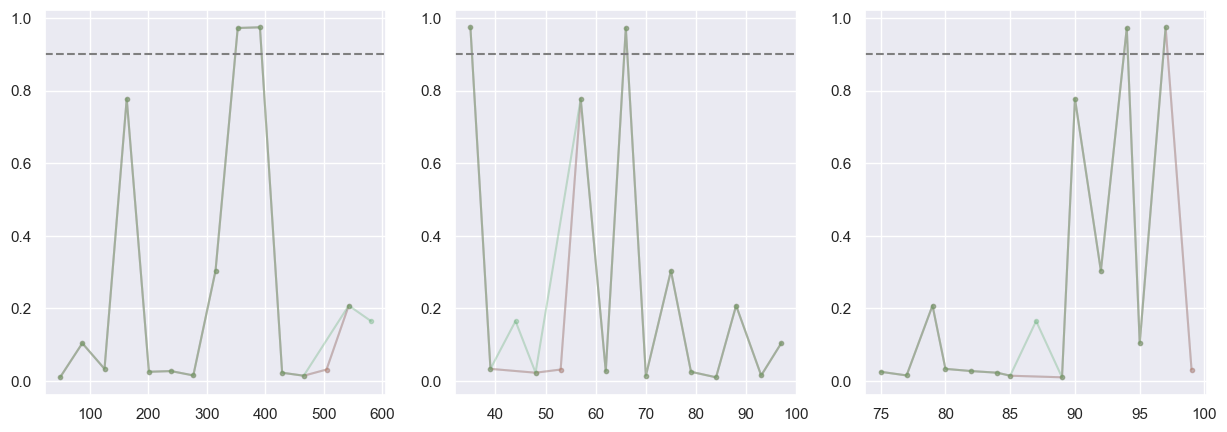

In [25]:
alpha = 0.3
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(df_bo[['EI_time','EI_out']][:ExpImp[5]].sort_values('EI_time')['EI_time'],df_bo[['EI_time','EI_out']][:ExpImp[5]].sort_values('EI_time')['EI_out'],'.-',alpha=alpha)
plt.plot(df_bo[['UCB_time','UCB_out']][:UppCB[5]].sort_values('UCB_time')['UCB_time'],df_bo[['UCB_time','UCB_out']][:UppCB[5]].sort_values('UCB_time')['UCB_out'],'.-',alpha=alpha)
plt.plot(df_bo[['PI_time','PI_out']][:ProbImp[5]].sort_values('PI_time')['PI_time'],df_bo[['PI_time','PI_out']][:ProbImp[5]].sort_values('PI_time')['PI_out'],'.-',alpha=alpha)
plt.axhline(0.90,linestyle = '--',color = 'tab:grey')


plt.subplot(1,3,2)
plt.plot(df_bo[['EI_anly','EI_out']][:ExpImp[5]].sort_values('EI_anly')['EI_anly'],df_bo[['EI_anly','EI_out']][:ExpImp[5]].sort_values('EI_anly')['EI_out'],'.-',alpha=alpha)
plt.plot(df_bo[['UCB_anly','UCB_out']][:UppCB[5]].sort_values('UCB_anly')['UCB_anly'],df_bo[['UCB_anly','UCB_out']][:UppCB[5]].sort_values('UCB_anly')['UCB_out'],'.-',alpha=alpha)
plt.plot(df_bo[['PI_anly','PI_out']][:ProbImp[5]].sort_values('PI_anly')['PI_anly'],df_bo[['PI_anly','PI_out']][:ProbImp[5]].sort_values('PI_anly')['PI_out'],'.-',alpha=alpha)
plt.axhline(0.90,linestyle = '--',color = 'tab:grey')


plt.subplot(1,3,3)
plt.plot(df_bo[['EI_sulf','EI_out']][:ExpImp[5]].sort_values('EI_sulf')['EI_sulf'],df_bo[['EI_sulf','EI_out']][:ExpImp[5]].sort_values('EI_sulf')['EI_out'],'.-',alpha=alpha)
plt.plot(df_bo[['UCB_sulf','UCB_out']][:UppCB[5]].sort_values('UCB_sulf')['UCB_sulf'],df_bo[['UCB_sulf','UCB_out']][:UppCB[5]].sort_values('UCB_sulf')['UCB_out'],'.-',alpha=alpha)
plt.plot(df_bo[['PI_sulf','PI_out']][:ProbImp[5]].sort_values('PI_sulf')['PI_sulf'],df_bo[['PI_sulf','PI_out']][:ProbImp[5]].sort_values('PI_sulf')['PI_out'],'.-',alpha=alpha)
plt.axhline(0.90,linestyle = '--',color = 'tab:grey')

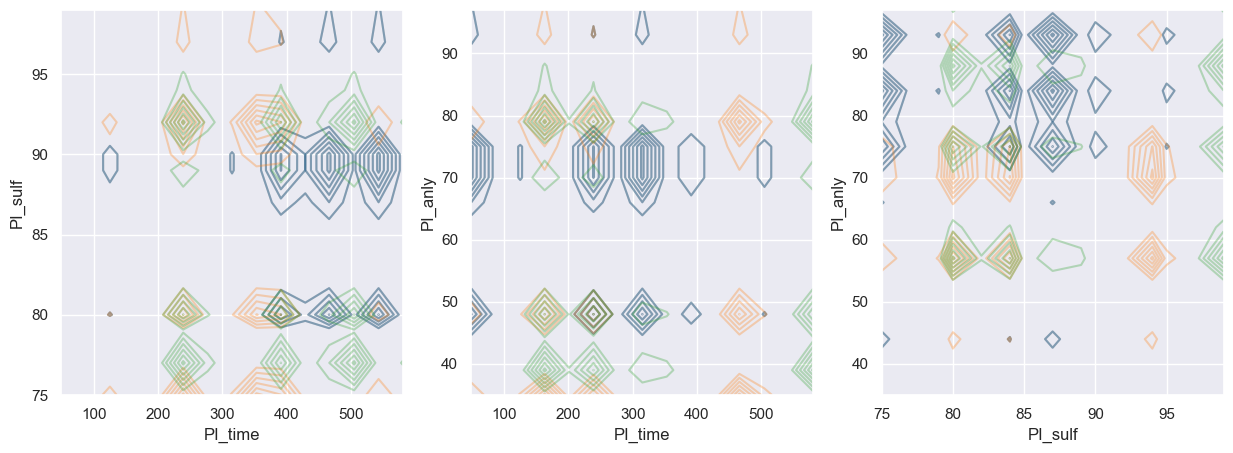

In [31]:
fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(15, 5))

contour_all(ax,avg_data,'time',"sulf",'yield product','k')
contour_all(ax,df_bo,'EI_time','EI_sulf','EI_out','tab:blue')
contour_all(ax,df_bo,'UCB_time','UCB_sulf','EI_out','tab:orange')
contour_all(ax,df_bo,'PI_time','PI_sulf','EI_out','tab:green')

contour_all(ax1,avg_data,'time','analyte','yield product','k')
contour_all(ax1,df_bo,'EI_time','EI_anly','EI_out','tab:blue')
contour_all(ax1,df_bo,'UCB_time','UCB_anly','EI_out','tab:orange')
contour_all(ax1,df_bo,'PI_time','PI_anly','EI_out','tab:green')

contour_all(ax2,avg_data,'sulf','analyte','yield product','k')
contour_all(ax2,df_bo,'EI_sulf','EI_anly','EI_out','tab:blue')
contour_all(ax2,df_bo,'UCB_sulf','UCB_anly','EI_out','tab:orange')
contour_all(ax2,df_bo,'PI_sulf','PI_anly','EI_out','tab:green')

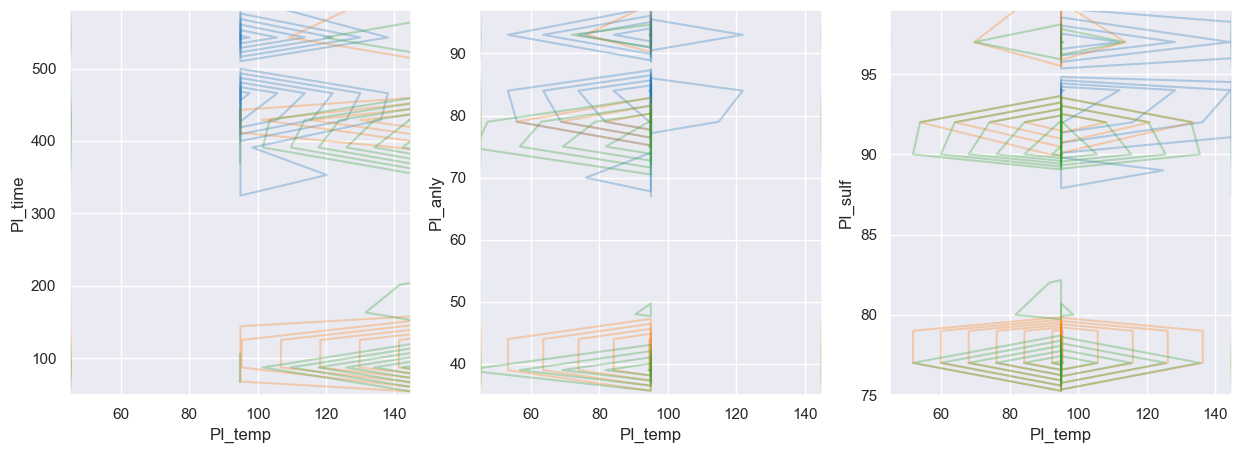

In [27]:
#Tempearture Plots
fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(15, 5))

#contour_all(ax,avg_data,'time',"sulf",'yield product','k')
contour_all(ax,df_bo,'EI_temp','EI_time','EI_out','tab:blue')
contour_all(ax,df_bo,'UCB_temp','UCB_time','EI_out','tab:orange')
contour_all(ax,df_bo,'PI_temp','PI_time','EI_out','tab:green')

#contour_all(ax1,avg_data,'time','analyte','yield product','k')
contour_all(ax1,df_bo,'EI_temp','EI_anly','EI_out','tab:blue')
contour_all(ax1,df_bo,'UCB_temp','UCB_anly','EI_out','tab:orange')
contour_all(ax1,df_bo,'PI_temp','PI_anly','EI_out','tab:green')

#contour_all(ax1,avg_data,'time','analyte','yield product','k')
contour_all(ax2,df_bo,'EI_temp','EI_sulf','EI_out','tab:blue')
contour_all(ax2,df_bo,'UCB_temp','UCB_sulf','EI_out','tab:orange')
contour_all(ax2,df_bo,'PI_temp','PI_sulf','EI_out','tab:green')

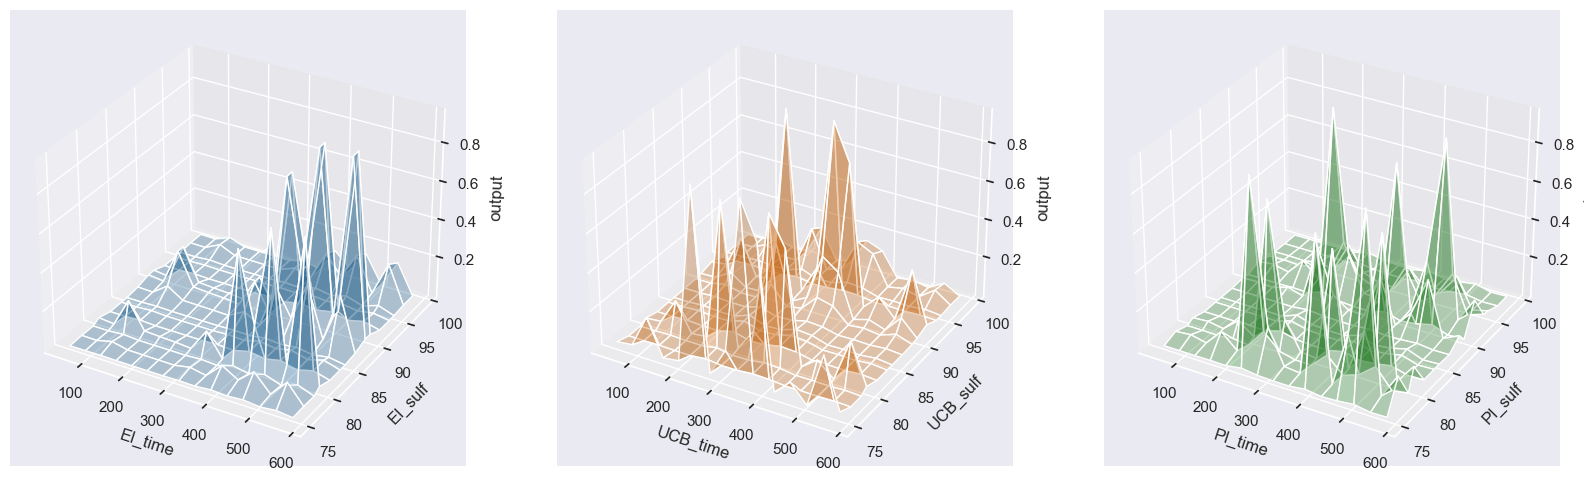

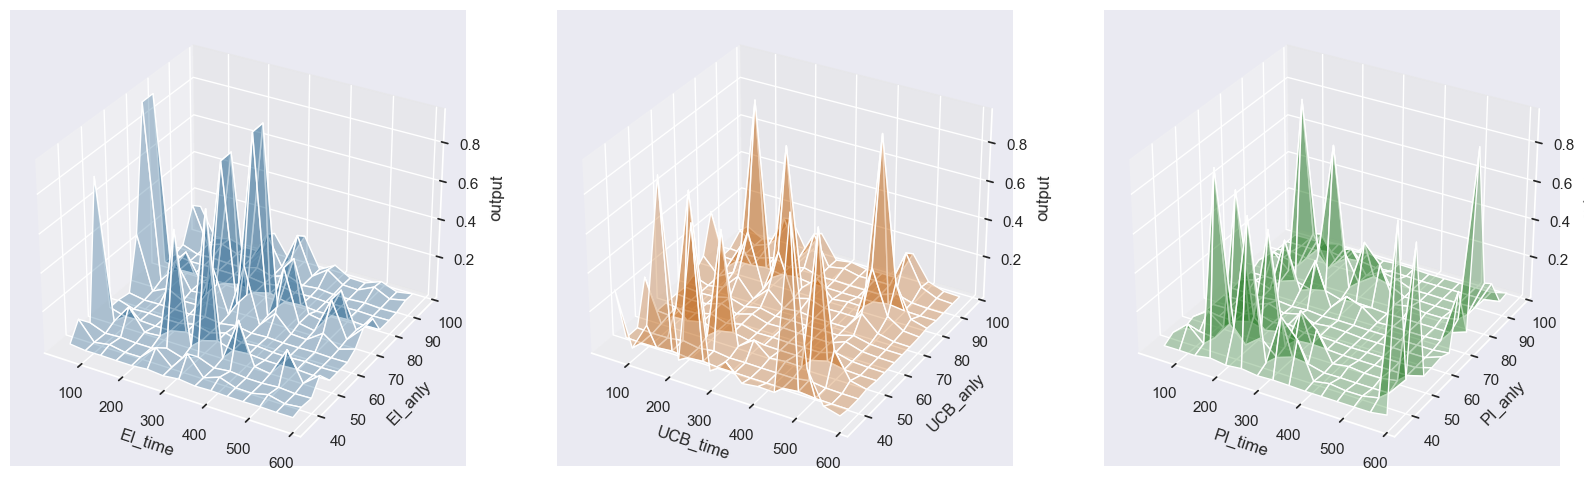

In [28]:
fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={'projection': '3d'})
surface_all(ax,df_bo,'EI_time','EI_sulf','EI_out','tab:blue')
surface_all(ax1,df_bo,'UCB_time','UCB_sulf','EI_out','tab:orange')
surface_all(ax2,df_bo,'PI_time','PI_sulf','EI_out','tab:green')

fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={'projection': '3d'})
surface_all(ax,df_bo,'EI_time','EI_anly','EI_out','tab:blue')
surface_all(ax1,df_bo,'UCB_time','UCB_anly','EI_out','tab:orange')
surface_all(ax2,df_bo,'PI_time','PI_anly','EI_out','tab:green')

Text(0.5, 1.0, 'Train Y')

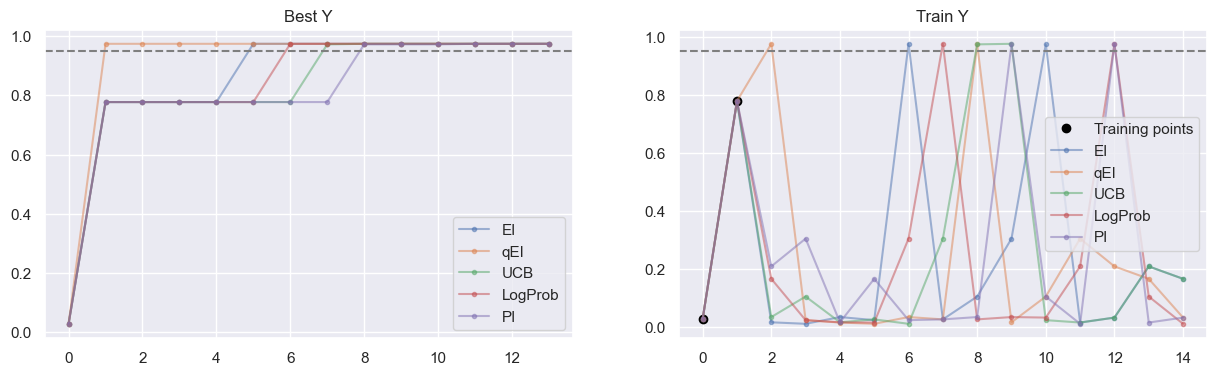

In [29]:
alpha = 0.5
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(ExpImp[0],'.-',alpha =alpha )
plt.plot(qExpImp[0],'.-',alpha =alpha)
plt.plot(UppCB[0],'.-',alpha =alpha)
plt.plot(PostMean[0],'.-',alpha =alpha)
plt.plot(ProbImp[0],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['EI', 'qEI','UCB','LogProb','PI'])
plt.title('Best Y')

plt.subplot(1,2,2)
plt.plot(abs(ExpImp[3][:2]),color = 'black', marker='o', linestyle='')
plt.plot(ExpImp[3],'.-',alpha =alpha)
plt.plot(qExpImp[3],'.-',alpha =alpha)
plt.plot(UppCB[3],'.-',alpha =alpha)
plt.plot(PostMean[3],'.-',alpha =alpha)
plt.plot(ProbImp[3],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['Training points','EI', 'qEI','UCB','LogProb','PI'])
plt.title('Train Y')



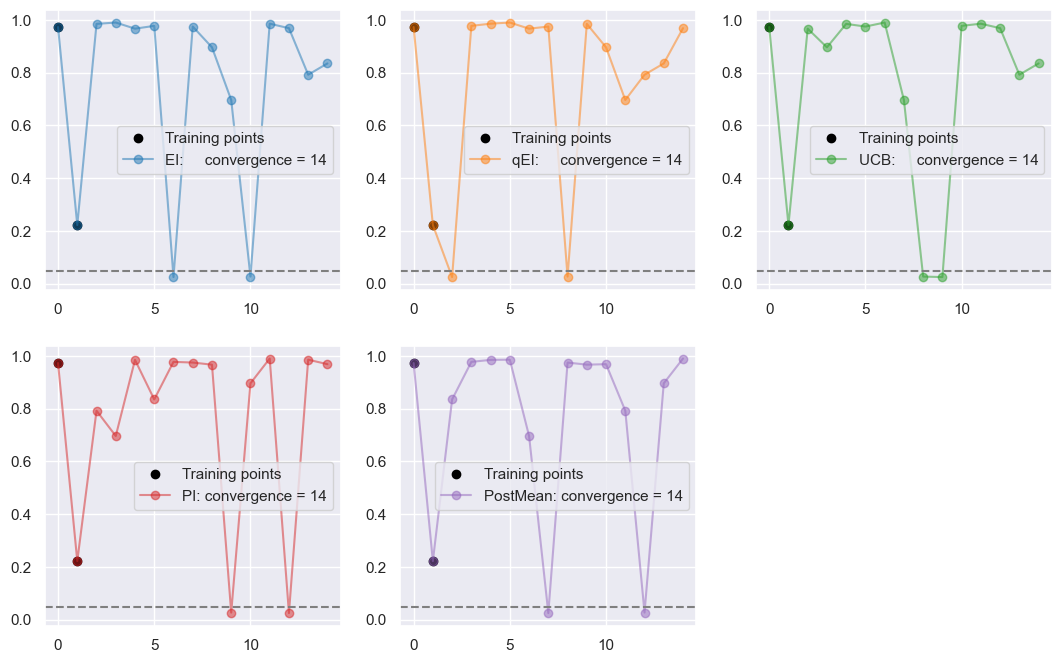

In [30]:
alpha=0.5
plt.figure(figsize=(13,8))
# plt.plot(np.arange(0,ExpImp[4]+1,1),   abs(ExpImp[0]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
# plt.plot(np.arange(0,qExpImp[4]+1,1), abs(qExpImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:orange')
# plt.plot(np.arange(0,UppCB[4]+1,1),abs(UppCB[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:green')
# plt.plot(np.arange(0,PostMean[4]+1,1),abs(PostMean[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:red')
# plt.plot(np.arange(0,ProbImp[4]+1,1),abs(ProbImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')
# plt.axhline(abs(0.95-best_f),linestyle = '--',color = 'tab:grey')

# plt.plot(np.arange(0,13,1),   abs(ExpImp[0]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
# plt.plot(np.arange(0,13,1), abs(qExpImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:orange')
# plt.plot(np.arange(0,13,1),abs(UppCB[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:green')
# plt.plot(np.arange(0,13,1),abs(PostMean[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:red')
# plt.plot(np.arange(0,13,1),abs(ProbImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')
# plt.axhline(abs(0.95-best_f),linestyle = '--',color = 'tab:grey')

aqi = [ExpImp[3],qExpImp[3],UppCB[3],ProbImp[3],PostMean[3]]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
legends = ['EI:     convergence = %s'%ExpImp[5],
            'qEI:     convergence = %s'%qExpImp[5],
            'UCB:     convergence = %s'%UppCB[5], 
            'PI: convergence = %s'%ProbImp[5],
            'PostMean: convergence = %s'%PostMean[5]]
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(abs(aqi[i][:train_size]-best_f.numpy()),color = 'black', marker='o', linestyle='')
    plt.plot(abs(aqi[i]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color=colors[i])
    #plt.plot(abs(ExpImp[3]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
    # plt.plot(abs(qExpImp[3]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:orange')
    # plt.plot(abs(UppCB[3]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:green')
    # plt.plot(abs(PostMean[3]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:red')
    # plt.plot(abs(ProbImp[3]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')
    plt.axhline(abs(0.95-best_f),linestyle = '--',color = 'tab:grey')
    plt.legend(['Training points',legends[i]])

# plt.plot(np.arange(0,43,1),   abs(ExpImp[0]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
# plt.plot(np.arange(0,43,1), abs(qExpImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:cyan')
# plt.plot(np.arange(0,43,1),abs(UppCB[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')


# plt.plot(iterations,best_y_values[1] , marker='o', linestyle='-', color='r')
# plt.plot(iterations,best_y_values[2] , marker='o', linestyle='-', color='g')
#plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
# plt.title('Spectra - Minimized Values Vs Iterations\n')
# plt.xlabel('Iteration')
# plt.ylabel('Best Distance Minimized')
# plt.grid(True)
# plt.legend(['EI:     convergence = %s'%ExpImp[4],
#             'qEI:     convergence = %s'%qExpImp[4],
#             'UCB:     convergence = %s'%UppCB[4], 
#             'PostMean: convergence = %s'%PostMean[4],
#             'PI: convergence = %s'%ProbImp[4]])


# Benchmarking

# Clustering